# Exercise 7.10

I am using the random walk problem introduced in the book, but with a behavior policy different than (0.5,0.5). I also included the *stay* action, that leaves the agent at the same place.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
class RandomWalkEnv:
	def __init__(self):
		num_states = 5
		self.states = np.arange(1, num_states + 1)  # Non-terminal states
		self.start_state = num_states // 2
		self.terminal_rewards = {0: 0, num_states + 1: 1}
	
	def reset(self):
		self.current_state = self.start_state
		return self.current_state

	def step(self, action):
		# Move randomly left or right
		if action == "left":
			self.current_state -= 1
		elif action == "right":
			self.current_state += 1
		elif action == "stay":
			self.current_state += 0
		else:
			raise ValueError("Invalid action")
		if self.current_state in self.terminal_rewards:
			reward = self.terminal_rewards[self.current_state]
			done = True
		else:
			reward = 0
			done = False
		return self.current_state, reward, done

In [3]:
def get_real_v(probs):
	pr = probs["right"]
	A = np.array([
		[-1, pr, 0, 0, 0],
		[1 - pr, -1, pr, 0, 0],
		[0, 1 - pr, -1, pr, 0],
		[0, 0, 1 - pr, -1, pr],
		[0, 0, 0, 1 - pr, -1]
	])
	b = np.array([0, 0, 0, 0, -pr])
	return np.linalg.solve(A, b)

get_real_v({"right": 0.5})

array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333])

In [4]:
b_probs = {
	'left': 0.4,
	'right': 0.4,
	'stay': 0.2
}

# Target policy
pi_probs = {
	'left': 0.5,
	'right': 0.5,
	'stay': 0.0
}

def generate_action(probs):
	return np.random.choice(list(probs.keys()), p=list(probs.values()))

def rho(pi_probs, b_probs, action):
	return pi_probs[action] / b_probs[action]

Disclaimer: there might be bugs present in the form of one-off indexing errors

In [5]:
class Base_class_algorithm():
    def __init__(self, env, b_probs, pi_probs):
        self.env = env
        self.b_probs = b_probs
        self.pi_probs = pi_probs
        self.V = np.zeros(len(env.states) + 2)
    
    def reset(self):
        self.V = np.zeros(len(self.env.states) + 2)
    
    def generate_and_learn(self, num_episodes, alpha, n, gamma, real_V):
        mse = []
        for _ in range(num_episodes):
            states = []
            actions = []
            rewards = [0] # just for indexing
            rhos = []
            
            states.append(self.env.reset())
            T = float('inf')
            t = 0
            while True:
                if t < T:
                    action = generate_action(self.b_probs)
                    rhos.append(rho(self.pi_probs, self.b_probs, action))
                    next_state, reward, done = self.env.step(action)
                    actions.append(action)
                    rewards.append(reward)
                    states.append(next_state)
                    if done:
                        T = t + 1

                tau = t - n + 1
                if tau >= 0:
                    self.update(tau, alpha, gamma, n, T, states, rewards, rhos)

                if tau == T - 1:
                    break
                t += 1
            mse.append(np.mean(np.square(self.V[1:-1] - real_V)))
        return mse

    
    def update(self, tau, alpha, gamma, n, T, states, rewards, rhos):
        pass

In [6]:
class Simple_algorithm(Base_class_algorithm):
    def update(self, tau, alpha, gamma, n, T, states, rewards, rhos):
        G = 0
        loop_end = min(n, T - tau) 
        for i in range(loop_end):
            G += gamma ** i * rewards[tau + i + 1]
        G += gamma ** loop_end * self.V[states[tau + loop_end]]

        rho_prod = 1
        for i in range(tau, min(tau + n, T)):
            rho_prod *= rhos[i]
        
        self.V[states[tau]] += alpha * rho_prod * (G - self.V[states[tau]])

In [7]:
class Control_variate_algorithm(Base_class_algorithm):
    def update(self, tau, alpha, gamma, n, T, states, rewards, rhos):
        G = self.get_G(tau, tau + n, gamma, T, states, rewards, rhos)
        self.V[states[tau]] += alpha * (G - self.V[states[tau]])

    def get_G(self, t, h, gamma, T, states, rewards, rhos):
        if t == h:
            return self.V[states[h]]
        elif t == T:
            return 0
        else:
            return rhos[t] * (rewards[t + 1] + gamma * self.get_G(t + 1, h, gamma, T, states, rewards, rhos)) + (1 - rhos[t]) * self.V[states[t]]

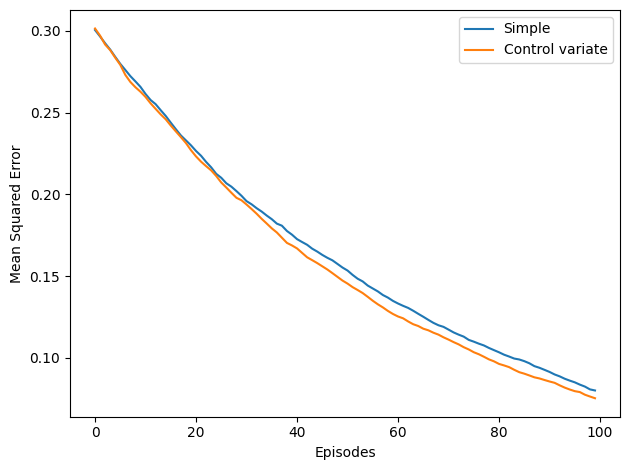

In [8]:
# Parameters
alpha = 0.01          # Learning rate
gamma = 1.0          # Discount factor
num_episodes = 100  # Number of episodes
num_runs = 100       # Number of runs
n = 4                # Number of steps for n-step TD

mean_mse_simple = np.zeros(num_episodes)
mean_mse_control = np.zeros(num_episodes)
# Real state values
real_V = get_real_v(pi_probs)
simple_algo = Simple_algorithm(RandomWalkEnv(), b_probs, pi_probs)
control_algo = Control_variate_algorithm(RandomWalkEnv(), b_probs, pi_probs)

for i in range(num_runs):
    simple_algo.reset()
    control_algo.reset()

    mean_mse_simple += simple_algo.generate_and_learn(num_episodes, alpha, n, gamma, real_V)
    mean_mse_control += control_algo.generate_and_learn(num_episodes, alpha, n, gamma, real_V)

mean_mse_simple /= num_runs
mean_mse_control /= num_runs

plt.plot(mean_mse_simple, label="Simple")
plt.plot(mean_mse_control, label="Control variate")
plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("../chapters_latex/figures/ex_07_10.pdf")
plt.show()